# Notebook 3. Use Experiments, Trials, and Search to Organize ML Experiments.

* Goals
    * Train Tensorflow and PyTorch models using custom training scripts.
    * Organize training using `Experiments` and `Trials`.
    * Use SageMaker Search functionality to find the best model.
* Code adapted from the following sample notebooks:
    * [tensorflow_script_mode_training_and_serving](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb)
    * [pytorch_mnist](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_mnist/pytorch_mnist.ipynb)

---
## 1. Setup

Change into the notebooks directory.

In [1]:
%cd /root/sagemaker-workshop-420/notebooks

/root/sagemaker-workshop-420/notebooks


In [2]:
import time

import boto3
import sagemaker
from sagemaker import get_execution_role

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [3]:
BUCKET = 'sagemaker-workshop-420'
PREFIX = 'mnist'

LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'

print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

Artifacts will be written to s3://sagemaker-workshop-420/mnist


First, lets create our Sagemaker session and role.

In [4]:
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_client = boto_session.client('sagemaker')
sagemaker_session = sagemaker.Session(boto_session=boto_session,
                                      sagemaker_client=sagemaker_client)
role = get_execution_role()
print(role)

arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200414T065516


## 1. Training a Tensorflow model

### 1a. Data

The MNIST dataset has been loaded to the public S3 buckets ``sagemaker-sample-data-<REGION>`` under the prefix ``tensorflow/mnist``. There are four ``.npy`` file under this prefix:
* `train_data.npy`
* `eval_data.npy`
* `train_labels.npy`
* `eval_labels.npy`

In [5]:
training_data_uri = f's3://sagemaker-sample-data-{region}/tensorflow/mnist'
training_data_uri

's3://sagemaker-sample-data-us-east-2/tensorflow/mnist'

### 1b. Training Script

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

In [6]:
# TensorFlow 2.1 script
!pygmentize '../scripts/tensorflow_mnist.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    mod

### 1c. Use Experiment to track experiment metadata

#### Step 1 - Create an Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : 

1. a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or 
2. a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”),
3. a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

In [7]:
mnist_experiment = Experiment.create(
    experiment_name=f"TF-mnist-{int(time.time())}", 
    description="Classification of mnist hand-written digits using tensorflow", 
    sagemaker_boto_client=sagemaker_client)

In [8]:
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f66baae95d0>,experiment_name='TF-mnist-1587040103',description='Classification of mnist hand-written digits using tensorflow',experiment_arn='arn:aws:sagemaker:us-east-2:209970524256:experiment/tf-mnist-1587040103',response_metadata={'RequestId': '2f1910ad-6c57-4422-836a-84f649117169', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2f1910ad-6c57-4422-836a-84f649117169', 'content-type': 'application/x-amz-json-1.1', 'content-length': '91', 'date': 'Thu, 16 Apr 2020 12:28:23 GMT'}, 'RetryAttempts': 0})


#### Step 2 - Track Experiment using Trials

Now create a Trial for each training run to track the it's inputs, parameters, and metrics.

In [9]:
trial_name = f"tensorflow-mnist-{int(time.time())}"

trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=mnist_experiment.experiment_name,
    sagemaker_boto_client=sagemaker_client,
)

#### Step 3. Initialize the Tensorflow Estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.
* `enable_sagemaker_metrics` is set to `True` to capture metrics like `accuracy` and `loss`

In [10]:
from sagemaker.tensorflow import TensorFlow

In [11]:
tf_estimator = TensorFlow(
    entry_point='../scripts/tensorflow_mnist.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    framework_version='2.1.0',
    code_location=f"s3://{BUCKET}/{PREFIX}",
    output_path=f"s3://{BUCKET}/{PREFIX}",
    py_version='py3',
    enable_sagemaker_metrics=True)

#### Step 4. Pass the Trial object to the Estimator and fit the model

**Note: This takes 3-5 minutes to return.**

In [12]:
# Now associate the estimator with the Experiment and Trial
tf_estimator.fit(
    inputs={'training': training_data_uri}, 
    job_name="tensorflow-training-job-{}".format(int(time.time())),
    experiment_config={
        "TrialName": trial.trial_name,
        "TrialComponentDisplayName": "Training",
    },
    wait=True,
)

INFO:sagemaker:Creating training-job with name: tensorflow-training-job-1587040123


2020-04-16 12:28:43 Starting - Starting the training job...
2020-04-16 12:28:45 Starting - Launching requested ML instances...
2020-04-16 12:29:44 Starting - Preparing the instances for training.........
2020-04-16 12:30:51 Downloading - Downloading input data...
2020-04-16 12:31:34 Training - Downloading the training image......
2020-04-16 12:32:43 Training - Training image download completed. Training in progress...2020-04-16 12:32:47,446 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-16 12:32:47,898 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://sagemaker-workshop-420/mnist/tensorflow-training-job

At this point you can view the `Experiment` metadata by clicking on the beaker icon in the vertical navigation bar on the left-side of your screen.

## 2. Hyperparameter Search with PyTorch models

We will use multiple `Trials` to perform hyperparameter search and find the best performing model.

In [13]:
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

from sagemaker.analytics import ExperimentAnalytics

### 2a. Dataset

We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [14]:
# Download, load, and transform the data.
train_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=True)

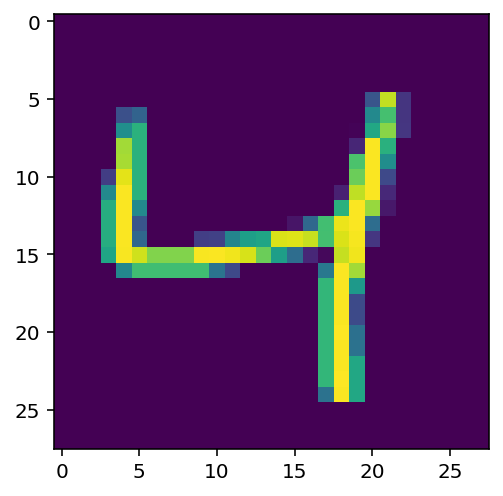

In [15]:
plt.imshow(train_set.data[2].numpy());

After transforming the images in the dataset, we upload it to s3.

In [16]:
inputs = sagemaker_session.upload_data(
    path=LOCAL_DATA_DIRECTORY,
    bucket=BUCKET,
    key_prefix=PREFIX)

### 2c. Use Experiment to track experiment metadata

### Step 1. Track preprocessing steps.

We'll first track the parameters from the data pre-processing step. These will then be passed to the hyperparameter jobs.

In [17]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sagemaker_client) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 2 - Create an Experiment

In [18]:
mnist_experiment = Experiment.create(
    experiment_name=f"torch-mnist-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sagemaker_client)

In [19]:
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f66baae95d0>,experiment_name='torch-mnist-1587040473',description='Classification of mnist hand-written digits',experiment_arn='arn:aws:sagemaker:us-east-2:209970524256:experiment/torch-mnist-1587040473',response_metadata={'RequestId': '6c457e34-42d6-4214-8e7c-753091c94253', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '6c457e34-42d6-4214-8e7c-753091c94253', 'content-type': 'application/x-amz-json-1.1', 'content-length': '94', 'date': 'Thu, 16 Apr 2020 12:34:32 GMT'}, 'RetryAttempts': 0})


### Step 3 - Track Experiment

While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

**Note: This takes ~15 minutes to return.**

In [20]:
from sagemaker.pytorch import PyTorch

# Keep references to each Trial object
hidden_channel_trial_name_map = {}
preprocessing_trial_component = tracker.trial_component

# If you want to run the following training jobs asynchronously, you may need to increase
# your resource limit. Otherwise, you can run them sequentially.
for i, num_hidden_channel in enumerate([2, 5, 10]):
    
    # create Trial oobject
    trial_name = f"torch-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sagemaker_client,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # Associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='../scripts/pytorch_mnist.py',
        role=role,
        sagemaker_session=sagemaker_session,
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        code_location=f"s3://{BUCKET}/{PREFIX}",
        output_path=f"s3://{BUCKET}/{PREFIX}",
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True,
    )
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2020-04-16-12-34-37-047


2020-04-16 12:34:37 Starting - Starting the training job...
2020-04-16 12:34:39 Starting - Launching requested ML instances...
2020-04-16 12:35:34 Starting - Preparing the instances for training.........
2020-04-16 12:36:50 Downloading - Downloading input data...
2020-04-16 12:37:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-16 12:37:28,865 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-16 12:37:28,867 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-16 12:37:28,879 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-16 12:37:28,880 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-16 12:37:29,168 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generati

INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2020-04-16-12-38-52-470


2020-04-16 12:38:52 Starting - Starting the training job...
2020-04-16 12:38:54 Starting - Launching requested ML instances......
2020-04-16 12:39:53 Starting - Preparing the instances for training...
2020-04-16 12:40:34 Downloading - Downloading input data...
2020-04-16 12:41:16 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-16 12:41:17,056 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-16 12:41:17,058 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-16 12:41:17,070 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-16 12:41:20,083 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-16 12:41:20,554 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generating 

INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2020-04-16-12-42-36-957


2020-04-16 12:42:37 Starting - Starting the training job...
2020-04-16 12:42:38 Starting - Launching requested ML instances...
2020-04-16 12:43:36 Starting - Preparing the instances for training......
2020-04-16 12:44:16 Downloading - Downloading input data...
2020-04-16 12:45:01 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-16 12:45:02,652 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-16 12:45:02,655 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-16 12:45:02,666 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-16 12:45:02,668 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-16 12:45:02,921 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generating

### Step 4. Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

In [21]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [22]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,sagemaker-pytorch-2020-04-16-12-42-36-957-aws-...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,sagemaker-pytorch-2020-04-16-12-34-37-047-aws-...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
2,sagemaker-pytorch-2020-04-16-12-38-52-470-aws-...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [23]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [24]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2020-04-16-123430-hkbo,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sagemaker-pytorch-2020-04-16-12-34-37-047-aws-...,Training,NaN,NaN,arn:aws:sagemaker:us-east-2:209970524256:train...,520713654638.dkr.ecr.us-east-2.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0
